In [1]:
!pip install imbalanced-learn lightgbm

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import joblib

# Step 1: Load dataset
df = pd.read_csv("/content/40k-balanced.csv")

# Step 2: Drop completely empty columns
df = df.dropna(axis=1, how='all')

# Step 3: Ensure 'loan_status' exists and drop rows where it's missing
if 'loan_status' not in df.columns:
    raise ValueError("Target column 'loan_status' not found.")
df = df.dropna(subset=['loan_status'])

# Step 4: Encode categorical features
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Step 5: Feature matrix and target vector
X = df.drop(columns=['loan_status'])
y = df['loan_status']

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 7: Impute missing values
imputer = SimpleImputer(strategy='mean')  # You can also try 'median' or 'most_frequent'
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Step 8: Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Fine-tuned LightGBM model
model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    min_data_in_leaf=50,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=1.0,
    random_state=42
)

model.fit(X_train_res, y_train_res)


# Step 10: Predict and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] if len(model.classes_) == 2 else None

print("Classification Report:\n", classification_report(y_test, y_pred))
if y_prob is not None:
    print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
else:
    print("ROC AUC not available for multi-class classification.")


# Save feature columns
joblib.dump(X.columns.tolist(), 'feature_columns.pkl')



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 16000, number of negative: 16000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3092
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.69      0.74      4000
           1       0.73      0.83      0.78      4001

    accuracy                           0.76      8001
   macro avg       0.77      0.76      0.76      8001
weighted avg       0.77      0.76      0.76      8001

ROC AUC Score: 0.8455898525368659


['feature_columns.pkl']

In [3]:
# Save LightGBM model and imputer
joblib.dump(model, 'loan_model_lgbm.pkl')
joblib.dump(imputer, 'loan_imputer.pkl')


['loan_imputer.pkl']

In [4]:
import pandas as pd
import numpy as np
import pickle

# Load the feature column names from the pickle file
with open('feature_columns.pkl', 'rb') as f:
    feature_columns = pickle.load(f)

# Take 5 random rows from real test set
base_samples = pd.DataFrame(X_test, columns=feature_columns).sample(10, random_state=42)

# Create small variations to simulate new applicants
synthetic_test_cases = base_samples.copy()
for col in ['loan_amnt', 'int_rate', 'dti', 'revol_util', 'installment', 'revol_bal']:
    if col in synthetic_test_cases.columns:  # Check to avoid KeyErrors
        synthetic_test_cases[col] = synthetic_test_cases[col] * np.random.uniform(0.9, 1.1, size=10)

# Clip values to prevent unrealistic ranges
synthetic_test_cases = synthetic_test_cases.clip(lower=0)

# Display test cases
synthetic_test_cases.head(10)


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
2215,6709.755546,0.0,9.104037,242.683527,1.0,6.0,21034.0,6.0,0.0,55000.0,...,9.0,1.0,15576.742833,74.640276,31.0,1.0,1.0,2.0,1.0,13922.0
2582,25955.895752,1.0,17.452257,726.294903,3.0,18.0,6548.0,0.0,3.0,60000.0,...,16.0,0.0,32226.916102,44.635697,47.0,0.0,1.0,1.0,0.0,31836.0
1662,4269.276062,0.0,10.347216,129.838583,1.0,7.0,1538.0,5.0,4.0,55000.0,...,8.0,1.0,521.592337,3.753186,22.0,0.0,1.0,3.0,1.0,27660.0
3027,17274.033677,0.0,12.070529,530.550145,1.0,7.0,4030.0,1.0,4.0,57100.0,...,6.0,3.0,7956.023147,65.816584,10.0,1.0,1.0,0.0,0.0,24525.0
6974,24299.092271,0.0,6.515172,778.679877,0.0,0.0,7291.0,1.0,0.0,96000.0,...,12.0,0.0,9072.505399,27.819061,21.0,1.0,1.0,1.0,0.0,3181.0
2680,21922.167129,1.0,13.610011,497.261916,2.0,12.0,20974.0,3.0,4.0,85000.0,...,10.0,1.0,13242.188775,79.421863,28.0,1.0,1.0,1.0,1.0,6745.0
1765,26285.764176,1.0,15.638198,755.534479,3.0,18.0,4052.0,3.0,0.0,80000.0,...,9.0,0.0,23747.425225,53.916767,15.0,1.0,1.0,1.0,0.0,39890.0
1123,16457.804897,0.0,11.235194,575.426222,1.0,6.0,21200.0,5.0,4.0,80000.0,...,13.0,0.0,7765.350219,33.673703,17.0,0.0,1.0,0.0,0.0,1472.0
4055,9491.494987,1.0,20.944613,282.018861,4.0,22.0,622.0,7.0,0.0,44460.0,...,8.0,0.0,8215.694667,60.876492,13.0,0.0,1.0,2.0,0.0,29212.0
3454,7238.240028,0.0,10.599590,243.679124,1.0,7.0,1399.0,2.0,4.0,80000.0,...,13.0,0.0,4597.760971,12.808035,22.0,1.0,1.0,0.0,0.0,7842.0


In [5]:
# Impute and predict
X_synth = imputer.transform(synthetic_test_cases)
preds = model.predict(X_synth)
probs = model.predict_proba(X_synth)[:, 1]

# Display results
for i in range(len(preds)):
    print(f"Case {i+1}: Predicted = {preds[i]}, Default Probability = {probs[i]:.2f}")


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
Case 1: Predicted = 1, Default Probability = 0.74
Case 2: Predicted = 0, Default Probability = 0.26
Case 3: Predicted = 1, Default Probability = 0.90
Case 4: Predicted = 1, Default Probability = 0.73
Case 5: Predicted = 1, Default Probability = 0.82
Case 6: Predicted = 0, Default Probability = 0.36
Case 7: Predicted = 0, Default Probability = 0.44
Case 8: Predicted = 0, Default Probability = 0.00
Case 9: Predicted = 0, Default Probability = 0.00
Case 10: Predicted = 1, Default Probability = 0.82


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


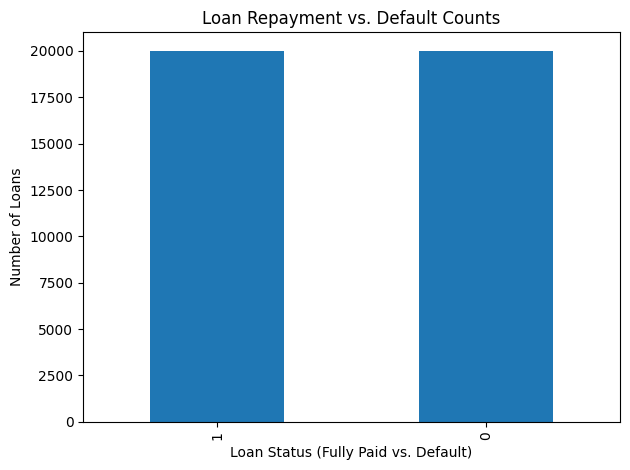

In [6]:
import matplotlib.pyplot as plt

df['loan_status'].value_counts().plot(kind='bar')
plt.title('Loan Repayment vs. Default Counts')
plt.xlabel('Loan Status (Fully Paid vs. Default)')
plt.ylabel('Number of Loans')
plt.tight_layout()
plt.show()


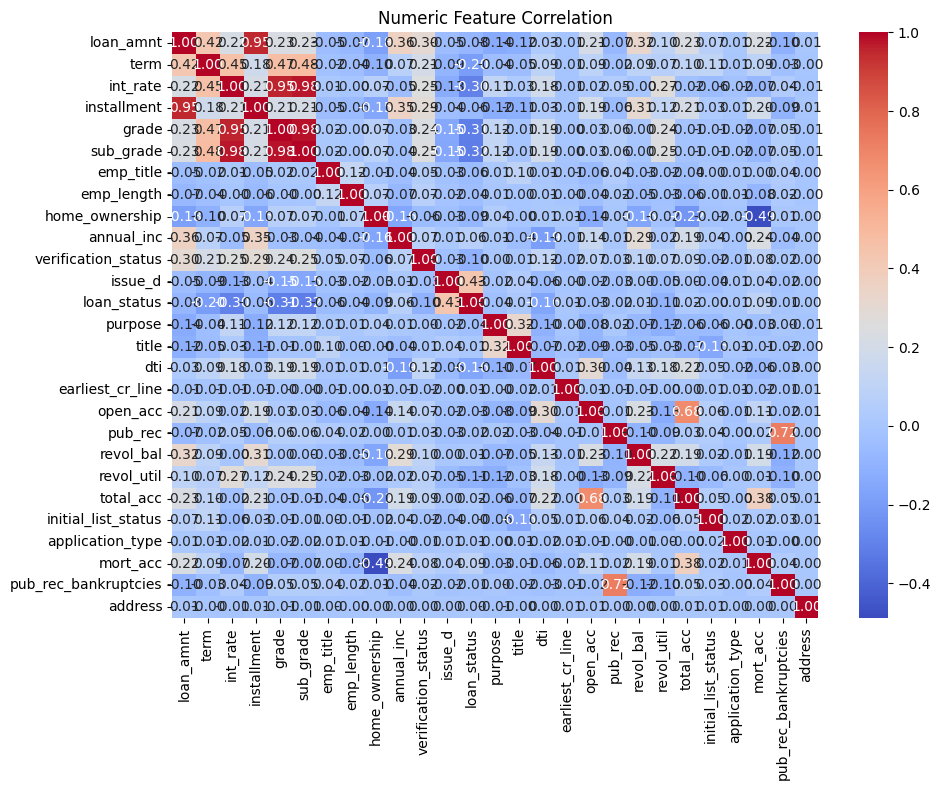

In [7]:
import seaborn as sns

numeric = df.select_dtypes(include=['int64','float64'])
corr = numeric.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Numeric Feature Correlation')
plt.tight_layout()
plt.show()

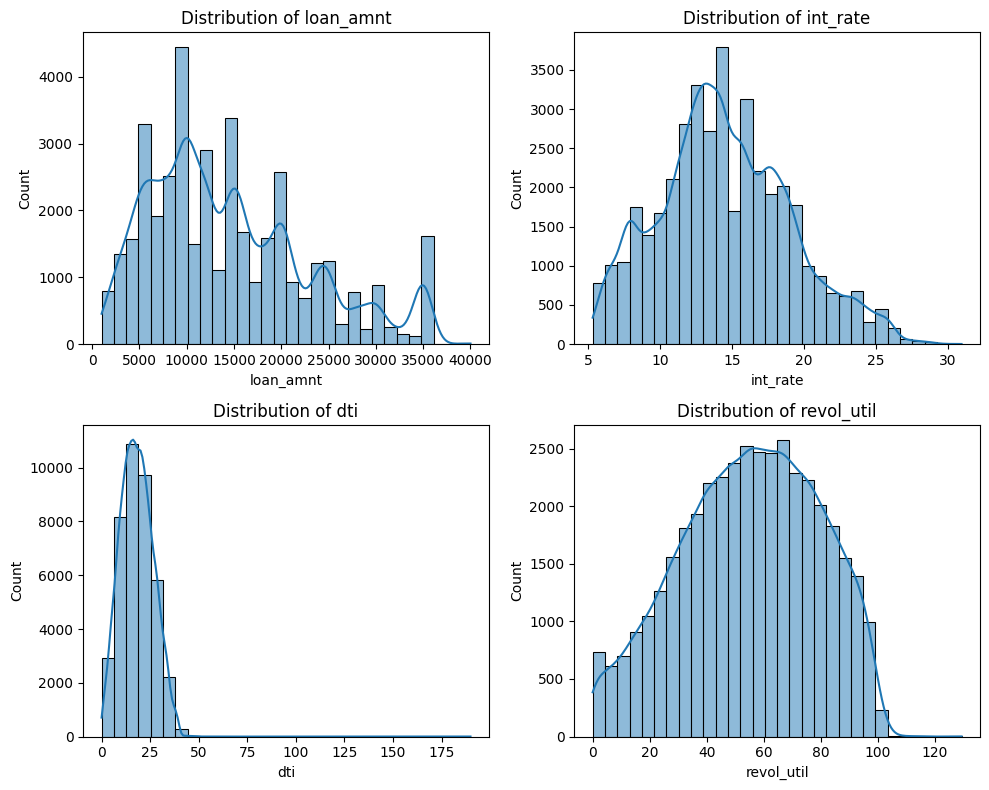

In [8]:
features = ['loan_amnt','int_rate','dti','revol_util']
fig, axes = plt.subplots(2,2, figsize=(10,8))
for feat, ax in zip(features, axes.flatten()):
    sns.histplot(df[feat], bins=30, kde=True, ax=ax)
    ax.set_title(f'Distribution of {feat}')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


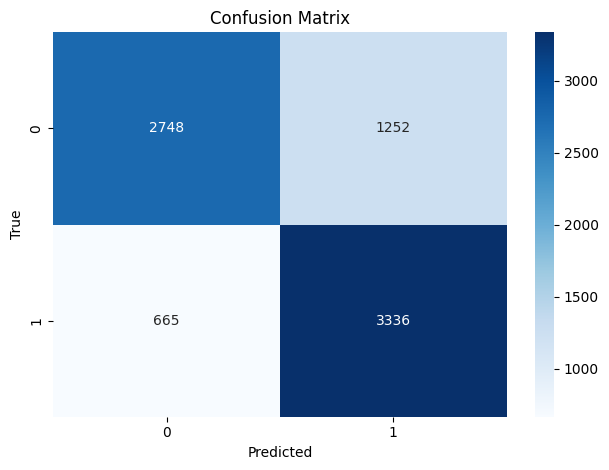

In [9]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


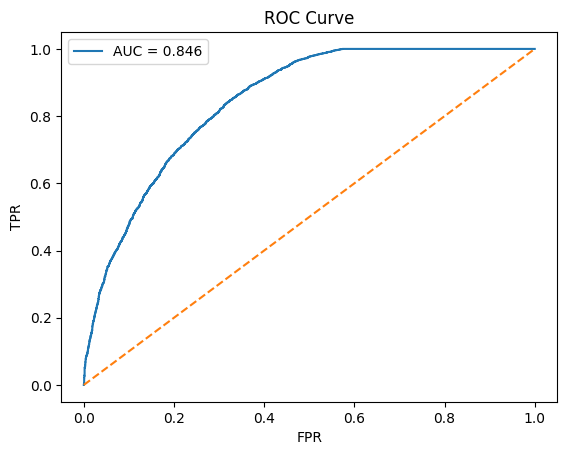

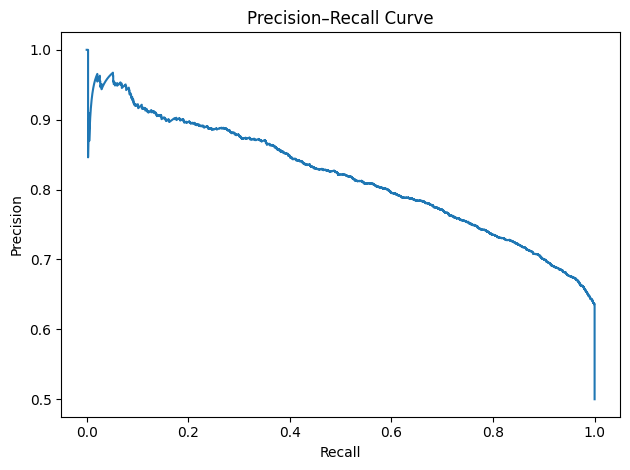

In [10]:
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1],[0,1],'--'); plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title('ROC Curve'); plt.legend(); plt.show()

prec, rec, _ = precision_recall_curve(y_test, y_prob)
plt.plot(rec, prec); plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision–Recall Curve'); plt.tight_layout(); plt.show()


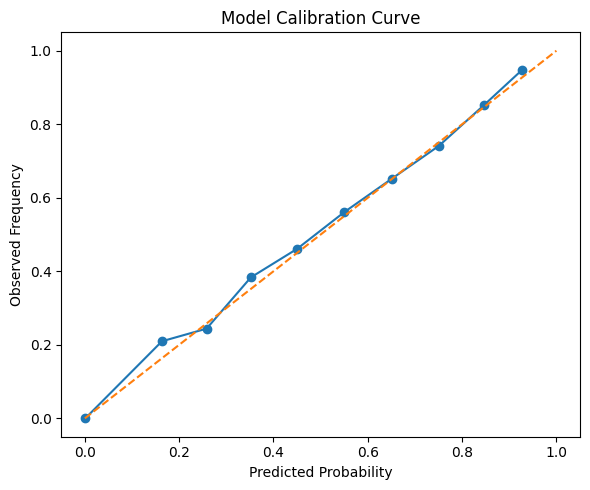

In [11]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Frequency')
plt.title('Model Calibration Curve')
plt.tight_layout()
plt.show()


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min

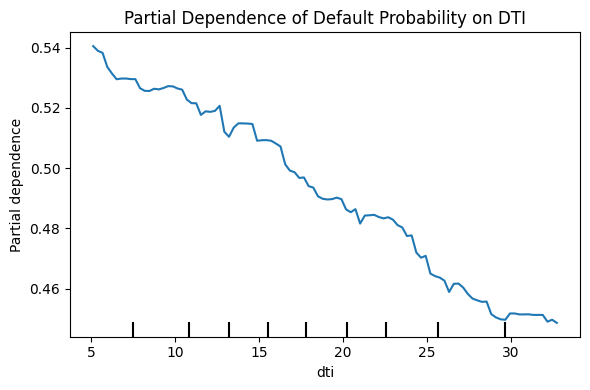

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# 1. If you still have your original DataFrame `df`, get the feature names from it:
#    (make sure you drop the target column here)
feature_names = df.drop('loan_status', axis=1).columns.tolist()

# 2. Reconstruct X_test as a DataFrame using those names
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# 3. Sanity check
assert 'dti' in X_test_df.columns, f"'dti' not found in columns: {X_test_df.columns.tolist()}"

# 4. Plot the partial dependence
fig, ax = plt.subplots(figsize=(6, 4))
PartialDependenceDisplay.from_estimator(
    model,
    X_test_df,
    ['dti'],    # exact feature name
    ax=ax
)
ax.set_title('Partial Dependence of Default Probability on DTI')
plt.tight_layout()
plt.show()

